### Introduction to Convolutional Neural Network using MNIST

This kernel aims at creating a multiclass classifier to handwritten digits by training our model on MNIST dataset.

- We will try to understand why we are using convnets for this task and why they are popular for computer vision
- Understand how convolution works
- How different layers, like Pooling, Flattening and Dropout work
- Then we will build our model and use it to predict the test dataset

#### What is Convolution?

A convolution is an operation that basically represents how the shape of one function is modified by the other. In CNN, we use kernels or feature detectors which act as a filter to our initial input. These filters are usually of 3x3 or 5x5 sizes and slide over our 3D input, stopping at every possible location and extracting features to produce the feature map. 



$$(f*g)(t)\;\triangleq\int_{-\infty}^{\infty} f(\tau)\;g(t-\tau) \;d\tau$$ 


The convolution works by element wise multiplication of the kernel and the 3D input as it passes over it and sums it all to give 1 value of the output feature map, thus reducing the size of input matrix.

We pass a number of feature detectors to the convolution layer, each of them producing a different output by retaining information from different parts of the image. This is called the depth of the output feature map. 

Unlike the densely connected layer a convolution layer can learn feature irrespective of its position in the image. For instance, after learning a certain pattern at the lower right corner of the image, a covnet can recognise it anywhere. Where as a densely connected layer has to learn the same pattern at the new location in order to recognise it. 

The reason covnets are so popular for computer vision is because they preserve the spatial hierarchies of patterns. The layers start learning from small patterns like edges, and then the next layer will learn something bigger based on the output of first layer.

Convolution work on 3D tensor, width, height and depth of the image. A tensor is simple a multi dimensional array. A matrix can be classified as a order 2 tensor. Since we are using grayscale images hence the depth will be 1. In case of colour image, the depth will be 3 because of the rbg scale. In case you ever need to work with Videos, an additional dimension, frame rate would make it a 4D tensor.

Let's see how a convolution filter works.

In [1]:
import os
os.chdir("D:\Study\Deep-LearningA-Z\Deep_Learning_A_Z\Volume 1 - Supervised Deep Learning\Part 2 - Convolutional Neural Networks (CNN)\Section 8 - Building a CNN\Convolutional_Neural_Networks")

In [5]:
from PIL import Image, ImageFilter ## To read and filter the image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [6]:
im = Image.open("shutterstock_aero.jpg")

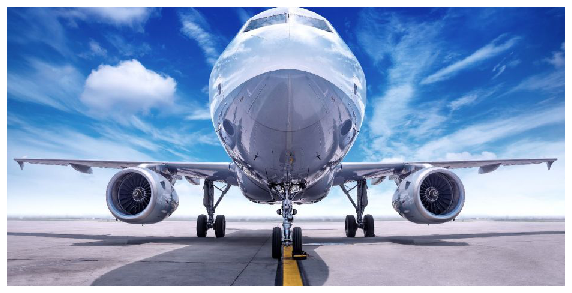

In [8]:
plt.figure(figsize=(10,8))
plt.axis('off')
imshow(im);

That's a cool picture. Let's see how convolution works by using a 3x3 filter on the image.



$$
g=
\begin{pmatrix}
-2 & -1 & 0\\
-1 & 1 & 1\\
0 & 1 & 2
\end{pmatrix}	$$

This filter will start from the upper left corner and move 1 stride each time transforming the Image till it reaches the end (Bottom right). Increasing the stride can enable a greater dimensionality reduction and make the process faster but at the same time there is chance of loosing on information.

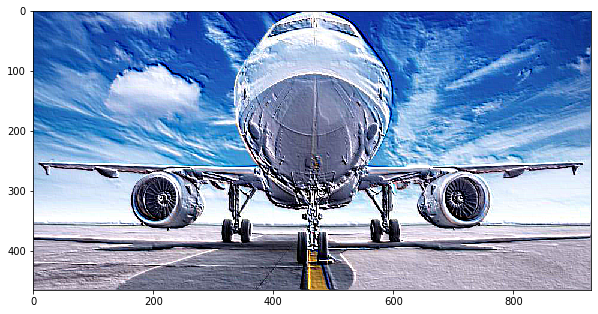

In [9]:
emboss = [-2,-1,0,-1,1,1,0,1,2] # This perticular matrix is called emboss
kernel = ImageFilter.Kernel((3,3), emboss)
 
im2 = im.filter(kernel)
plt.figure(figsize=(10,8))
plt.xticks=[]
imshow(im2);


##### See the difference? Now let's get started on building our classifier.


#### Importing Libraries

- MaxPooling: The function of pooling layer is downsizing the feature maps. It works in a similar fashion as convolution. It just extracts windows from the input feature and outputs the maximum value of the elements under that window. You will see how it reduces the feature maps which in turn reduces the number of parameters.

- Flattening: After we apply pooling, we are going to flatten the 3-dimensional pooled feature map to a 1D array. The reason for this is we want to input it to an artificial neural network/ dense layer for further processing.

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical # to convert our lables to catagories
import collections #to get count the number of each label
from sklearn.model_selection import train_test_split #To split the training set into Train + Validation data

Using TensorFlow backend.


In [18]:
import pylab
pylab.rc('figure', figsize=(10,7))

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### Building Classifier

I am going to use a network consisting of 2 Convolution layer, with 64 filters with 2x2 pooling patches. I am also going to drop some of the parameters to reduce the chances of overfitting. We will be sticking to `relu` activation functions for the all layers except for the output layer where we are going to use a non linear activation function `Softmax`

In [21]:
classifier=Sequential()

classifier.add(Conv2D(64,(3,3),input_shape=(28,28,1),activation='relu')) #by default the stride is 1
classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
classifier.add(Dropout(0.2))
classifier.add(Conv2D(64,(3,3),activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
classifier.add(Dropout(0.2))
classifier.add(Flatten())

classifier.add(Dense(units=256,activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=10,activation='softmax'))



Now our architecture is ready, let's take a look at it.

You, see can see how MaxPooling reduces the dimension to almost half. From 26 to 13 and then 11 to 5.

In [22]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

I am going to compile my model with `adam` optimizer as i think it is working better than `RMSprop` for me.

In [23]:
classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

### Load and transform data

In [29]:
(Train_data,train_label),(Test_data,test_label)=mnist.load_data()
X=Train_data.reshape(Train_data.shape[0],Train_data.shape[1],Train_data.shape[2],1)
X_test=Test_data.reshape(Test_data.shape[0],Test_data.shape[1],Test_data.shape[2],1)
y=train_label

X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.1, random_state=42)

In [30]:
Train_data.shape

(60000, 28, 28)

Now since we are doing multi-class classification, we have to `one hot encode` our labels to be able to pass it through our model.
Also, we are going to `normalise` the training data between 0 and 1. Since each pixel is represented by an 8-bit value that ranges from `0` to `255`, simply dividing the feature maps by 255 will get the job done. This is because NN prefer to deal with small input values and would converge faster.

In [27]:
y_train=to_categorical(y_train,10)
y_val=to_categorical(y_val,10)

X_train=X_train/255
X_val=X_val/255


#### Visualiseing the training images 

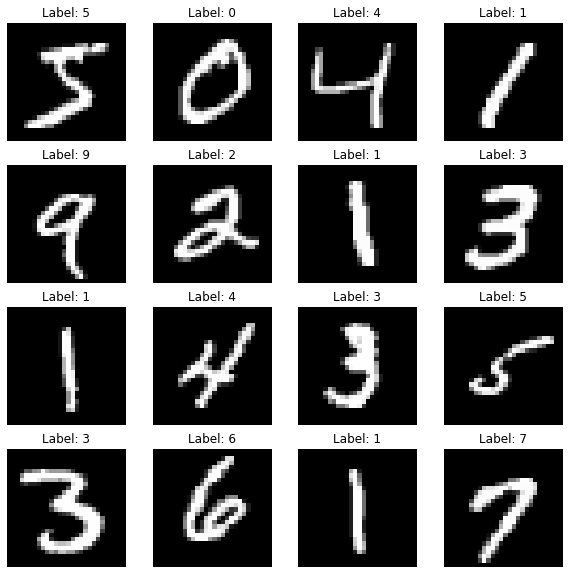

In [14]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title(f"Label: {train_label[i]}",fontdict={'size'   : 12})
    plt.gca().set_xticks([])
    #plt.xticks([])
    #plt.yticks([])
    plt.grid(False)
    plt.axis('off')
    plt.imshow(Train_data[i], cmap='gray')
plt.show()

#### Check the frequency of each digit in our training data and how they are distributed.

In [15]:
def sort_dic(dic):  # Sort the counter dictionaries 
    index=sorted(dic)
    sort_list=[]
    label=[]
    for i in index:
        sort_list.append(dic[i])
        label.append(i)
    return sort_list,label

In [16]:
train_count=collections.Counter(train_label)
train_count,labels=sort_dic(train_count)

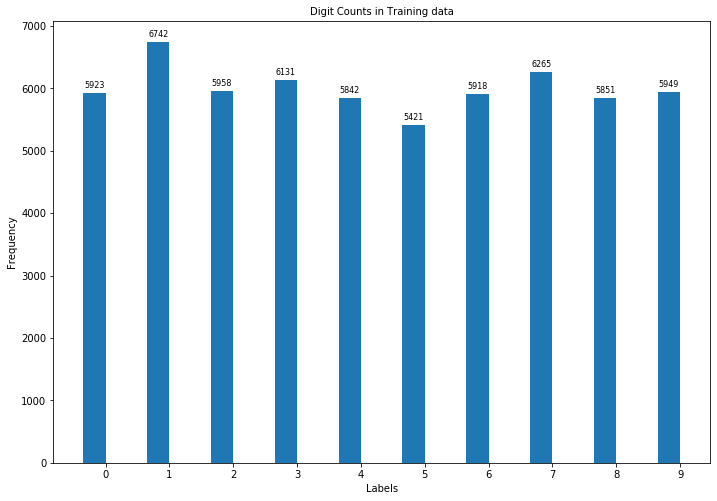

In [19]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_count, width, label='Train_label_Count')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel('Labels')
ax.set_title('Digit Counts in Training data')
ax.set_xticks(x)
ax.set_xticklabels(labels)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

fig.tight_layout()

plt.show()

#### Fit our model to training features and corresponding labels

In [28]:
classifier.fit(X_train,y_train,epochs=5,batch_size=128)
score=classifier.evaluate(X_val,y_val)
print("The accuracy of the model on test data is:",score[1])

Epoch 1/5
54000/54000 [==============================] - 33s 614us/step - loss: 0.2776 - accuracy: 0.9120
Epoch 2/5
54000/54000 [==============================] - 33s 602us/step - loss: 0.0859 - accuracy: 0.9736
Epoch 3/5
54000/54000 [==============================] - 32s 602us/step - loss: 0.0642 - accuracy: 0.9809
Epoch 4/5
54000/54000 [==============================] - 33s 613us/step - loss: 0.0500 - accuracy: 0.9845
Epoch 5/5
6000/6000 [==============================] - 1s 201us/step
The accuracy of the model on test data is: 0.9908333420753479


#### Great, we got an accuracy of 99.23%. That's not bad considering the siplicity of our model.
#### Now that our model is ready, let's predict the test labels

In [25]:
y_pred=classifier.predict(X_test)
pred_label=np.argmax(y_pred,axis=1)  ##Convert the results to class labels

#### How many of each digits mis classified?

In [33]:
error=pred_label!=test_label
missclassified_images=Test_data[error]
missclassified_label=pred_label[error]
correct_label=test_label[error]

print(f"Percentage of images misclassified: {len(missclassified_images)/len(test_label)*100} %")

Percentage of images misclassified: 0.76 %


In [27]:
pred_counts=collections.Counter(pred_label)  ##Getting the frequencies
labels_count=collections.Counter(test_label)

prediction_count,labels=sort_dic(pred_counts) ##Sorting the dictionary
actual_count,labels=sort_dic(labels_count)

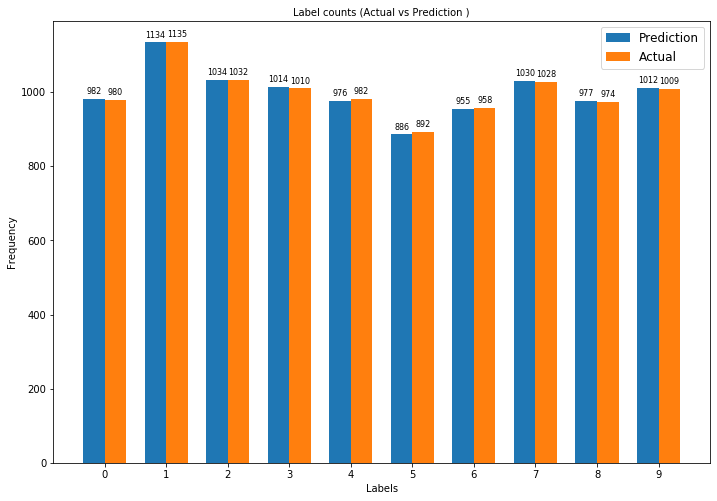

In [28]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, prediction_count, width, label='Prediction')
rects2 = ax.bar(x + width/2, actual_count, width, label='Actual')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel('Labels')
ax.set_title('Label counts (Actual vs Prediction )')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#### Next let's visualise some of the missclassified images

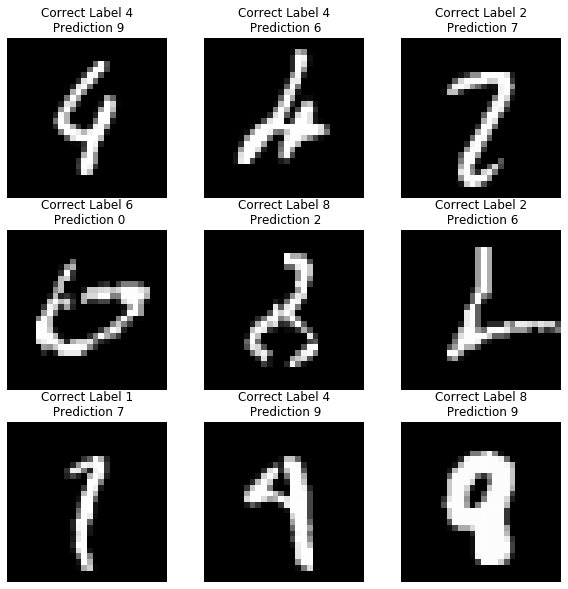

In [35]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title(f"True Label {correct_label[i]}\n Prediction {missclassified_label[i]}",fontdict={'size'   : 12})
    #plt.xticks([])
    #plt.yticks([])
    plt.axis('off')
    plt.grid(False)
    plt.imshow(missclassified_images[i], cmap='gray')
plt.show()

As you cab see some of these are even hard to comprehend for human eyes as well.

However, the model can be made more robust by making it a bit more complex.

- Using data augmentation: This is the process of generating more training data from the existing samples by using a number of random transformations. This will help the model to learn additional characteristics of data and generalise better to reduce overfitting.

- Dropout layer: Dropout layer let the model randomly drop a fraction of the units during forward or backward pass. This prevents units from co-adapting too much. Although I've already added dropouts, but the percentage of units we drop after each layer can be changed to see what works best.
     - Things to keep in mind is, dropping out too many units will take higher number of epochs for the model to learn.
     - However, the time taken for each epoch will decrease as there are less units to process.
     
I'll try exploring these options and update if find any better results.

Let me know in the comments any ideas that you might have to enhance the model.

### Thanks